Let's do some model development.

We're trying to prod people to spend money. Assuming no long term effects like: retention rates, customer annoyance, long term habit building, customer satisfaction. So we're trying to prod them to spend money over the short term.

Business scenarios:

- Assuming no transaction history built into model.
    - New customer, no demo info, what to offer them.
        - Basically no info at all. Offer aggregate best, or in model solely with customer length.
    - New customer, demo info, what to offer them.
        - Use model based on age, gender, income, possibly in model with customer length.
    - Existing customer, no demo info, what to offer them.
        - Use model based on customer length. Possibly by year as bin.
    - Existing customer, demo info, what to offer them.
        - Use model based on age, gender, income, customer length.
        
So we're looking for a way to pick out which offer to give a customer.

In our data, customers are only exposed to a maximum of 6 offers, with a median of 4 unique offers.


In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Sometimes use display instead of print
from IPython.display import display

# debugging
from IPython.core.debugger import set_trace

In [2]:
# Read the cleaned data
portfolio = pd.read_csv('./data/portfolio_clean.csv')
profile = pd.read_csv('./data/profile_clean.csv')
transcript = pd.read_csv('./data/transcript_clean.csv')

In [3]:
display(portfolio.head())
display(profile.head())
display(transcript.head())

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,168,10,10
1,2,1,1,1,1,bogo,120,10,10
2,3,1,1,1,0,informational,96,0,0
3,4,1,1,1,0,bogo,168,5,5
4,5,1,1,0,0,discount,240,20,5


,customer_id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
1,5,0,offer_received,NaN,NaN,5.0
2,6,0,offer_received,NaN,NaN,10.0
3,7,0,offer_received,NaN,NaN,7.0
4,8,0,offer_received,NaN,NaN,2.0


How to define success?

Base line behaviour

Split by customers? yes.

In [ ]:
# Merge everything first.
# df = transcript.merge(profile, how='left', on='customer_id').merge(portfolio, how='left', on='offer_id')

In [ ]:
# df = df.rename(columns={'reward_x':'reward_transaction', 'reward_y':'offer_reward'})

In [ ]:
# df.head()

In [ ]:
# A list of individual df's from grouping by customer id.
# train_customers, test_customers = train_test_split([e[1] for e in df.groupby('customer_id')], test_size=0.3, random_state=7)

In [ ]:
# display(len(train_customers))
# display(len(test_customers))

In [ ]:
# def split_transactions_and_offers(customer_list_of_df, transaction_key='transaction'):
#     """
#     Filters a agglomerated dataframe into transactions and offers.
    
#     Input:
#     customers_list_of_df - individual customer dfs in a list
#     transaction_key      - str for transaction events
    
#     Returns:
#         List of tuples of transaction and offer event dfs by customer id.
#     """
#     output = []
#     # Iterate through the list and split
#     for customer in customer_list_of_df:
#         # Mask to get transactions
#         select = customer.event == transaction_key
#         # Filter for transactions and 
#         output.append((customer[select], customer[~select]))
    
#     return output
    

In [ ]:
# train_event_split = split_transactions_and_offers(train_customers)

In [ ]:
# display(train_event_split[1][0])
# print('\n'*4)
# display(train_event_split[1][1])

# Simple KNN or something for only one type of offer? e.g. offer completion.

If I had to get a very simple classifier working to:
- predict whether off number 1, a bogo offer, was completed or not.
- predict based on demographic data.
    
To do that I would need to classify whether someone:
- got offer 1
- completed offer 1 within the specified duration

I'll split customers into training and validation.

To figure out if customers completed an offer or not, I'll need to:
- filter the transcript for 'offer_received' events for offer 1
- for each 'offer_received' event:
    - filter the transcript for 'offer_completed' events with time >= time of the received event and time <= t + duration

It's like

1) Grab the data by offer
2) Prep the data
3) Do the modelling and report results.
    - KNN pipeline
    - other model pipeline
4) Overall function.

In [62]:
def build_offer_with_demo_action_models(transcript_df,
                                        profile_df,
                                        portfolio_df,
                                        action_dict={'bogo': 'offer_completed',
                                                     'discount': 'offer_completed',
                                                     'informational': 'offer_viewed'},
                                        model_type='knn',
                                        test_size=0.3,
                                        verbosity=3,
                                        random_state=7):
    """
    Get models for offer viewing/completion.
    
    Input:
    transcript_df - Transaction/event transcript dataframe.
    profile_df    - Customer profiles.
    portfolio_df  - Offer portfolio.
    action_dict   - The action should the model predict for per offer.
    model_type    - Classifier to use. One of 'knn' (k nearest neighbours)
                    or 'rfc' (random forest classifier).
    test_size     - Split size for training/test sets.
    verbosity     - GridSearchCV verbosity level.
    random_state  - random_state to pass down to model building etc.
                  
    
    Returns:
    Dataframe containing columsn:
        offer_id - Offer ids.
        model    - GridSearchCV model for the offer.
        X_train  - Training data features.
        X_test   - Test data features.
        y_train  - Training data targets.
        y_test   - Test data targets.
    """
    output = pd.DataFrame(columns=['offer_id', 'model', 'X_train', 'X_test', 'y_train', 'y_test'])
    
    # Get offer ids and offer types,
    # then generate action type for based on offer type
    # (e.g. informational offers can only be viewed, not completed).
    offer_ids, offer_types = portfolio_df['offer_id'], portfolio_df['offer_type']
    offer_actions = [action_dict[offer_type] for offer_type in offer_types]
    
    for offer_id, action in zip(offer_ids, offer_actions):
        # Get combined customer profile + action completion df
        offer_profile = get_offer_action_data(transcript_df, profile_df, offer_id, action, contain_demo=True)
        # Get X and y 
        X, y = separate_x_y(offer_profile)
        # Split training and test
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=random_state)
        # Switch to build and cross validate a model.
        if model_type == 'knn':
            model = build_KNN_pipeline_and_fit_CV(X_train, y_train, verbosity=verbosity)
        elif model_type == 'rfc':
            model = build_RFC_pipeline_and_fit_CV(X_train, y_train, verbosity=verbosity)
        else:
            raise ValueError(f"Model of type {model_type} not implemented.")
        
        # Append the output
        output = output.append({'offer_id': offer_id,
                                'model': model, 
                                'X_train': X_train,
                                'X_test': X_test,
                                'y_train': y_train,
                                'y_test': y_test
                               }, ignore_index=True)
        
    return output

In [5]:
def get_offer_action_data(transcript_df, profile_df, offer_id, action_type, contain_demo=True):
    """
    For a given offer id, generates a df combining customer profiles with 
    whether they viewed/completed the offer (if they received the offer) over
    the course of the experiment.
    
    Also dummies gender data and converts "became_member_on" to 
    durations of how long a customer has been a customer.
    
    Input:
    transcript_df - Transaction/event transcript dataframe.
    profile_df    - Customer profiles.
    offer_id      - Offer id to process.
    action_type   - 'offer_completed' or 'offer_viewed'.
    contain_demo  - If True, returns only customers having age/gender/income demographic data.
                    If False, returns only customers without demographic data.
    
    Returns:
    offer_profile - Dataframe containing customer profiles and offer view/completion status.
    """
    tr = transcript_df
    pro = profile_df
    
    # Get set of offering completing and non-completing customer ids
    offer_customers = set(tr[(tr.offer_id == offer_id) & (tr.event == 'offer_received')].customer_id)
    offer_completed = set(tr[(tr.offer_id == offer_id) & (tr.event == action_type)].customer_id)
    offer_incomplete = offer_customers - offer_completed
    
    # Appending 0/1 for incomplete/complete to customer profile data
    profile_complete = pro[pro.customer_id.isin(offer_completed)].assign(offer_complete = 1)
    profile_incomplete = pro[pro.customer_id.isin(offer_incomplete)].assign(offer_complete = 0)
    
    offer_profile = pd.concat([profile_complete, profile_incomplete]).sort_values('customer_id')
    
    # Customers w/ demographic data
    if contain_demo == True:
        offer_profile = offer_profile.dropna()
    # Customers missing demographic data
    else:
        offer_profile = offer_profile[offer_profile.isna().any(axis=1)]
        
    # Clean the data
    ## Get dummies for gender
    offer_profile = pd.concat([offer_profile,
                               pd.get_dummies(offer_profile.gender, prefix="gender")],
                              axis=1)
    # Change membership date to duration in years of how long customer
    # has been a customer.
    customer_duration = pd.to_datetime(offer_profile.became_member_on)
    customer_duration = (customer_duration.max() - customer_duration).dt.days/365
    offer_profile['customer_duration'] = customer_duration
    
    # Drop unnecessary columns
    offer_profile = offer_profile.drop(columns=['gender', 'became_member_on', 'customer_id'])
    
    return offer_profile
    

In [6]:
def separate_x_y(df, y_key='offer_complete'):
    """
    Takes a df and separates it into X and y by y_key.
    
    Input:
    df     - A dataframe.
    y_key  - str of the y target column.
    
    Returns:
    X      - Dataframe without y_key column.
    y      - Series from y_key column.
    """
    # Get X and standardize it.
    # i.e. mean = 0, unit variance
    X = df.drop(columns=y_key)    
    y = df[y_key]
    
    return X, y

In [7]:
def build_KNN_pipeline_and_fit_CV(X_train, y_train, verbosity=3, n_neighbors_grid=[1,5,10,20,40,80,160,320,640,1000]):
    """
    Builds a KNN model and fits on training data with cross validation.
    
    Standardizes X data first before feeding into a KNN model.
    
    Input:
    X_train          - Training data features.
    y_train          - Training data targets.
    verbosity        - 0, 1, 2, or 3 to control GridSearchCV output.
    n_neighbors_grid - Search grid for the number of neighbors for the KNN model.
    
    Returns:
    model            - a GridSearchCV model.
    
    """
    pipe = Pipeline([('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier())])
    
    param_grid = [{'knn__n_neighbors': n_neighbors_grid}]
    model = GridSearchCV(pipe, scoring='f1', param_grid=param_grid, cv=5, refit=True, verbose=verbosity, return_train_score=True)
    
    model.fit(X_train, y_train)
    
    print(f"Best params: {model.best_params_}.")
    print(f"Best score: {round(model.best_score_, 5)}.")
    
    return model

In [20]:
def build_RFC_pipeline_and_fit_CV(X_train,
                                  y_train,
                                  verbosity=3,
                                  param_grid=[{'rfc__n_estimators': [10, 100],
                                               'rfc__max_depth': [100, None],
                                               'rfc__min_samples_split': [2, 5, 10, 20],
                                               'rfc__min_samples_leaf': [1, 2, 4, 8]
                                             }],
                                  random_state=7):
    """
    Builds a random forest classifier and fits on training data with cross validation.
    
    Standardizes X data first before feeding into a RF model.
    
    See https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    for hyperparameter tuning example.
    
    Input:
    X_train          - Training data features.
    y_train          - Training data targets.
    verbosity        - 0, 1, 2, or 3 to control GridSearchCV output.
    param_grid       - Search grid for the RF model. Prefix params with 'rfc__'.
    random_state     - random int for the RF model.
    
    Returns:
    model            - a GridSearchCV model.
    """
    pipe = Pipeline([('scaler', StandardScaler()),
                         ('rfc', RandomForestClassifier())])
    
 
    
    model = GridSearchCV(pipe, scoring='f1', param_grid=param_grid, cv=5, refit=True, verbose=verbosity, return_train_score=True)
    
    model.fit(X_train, y_train)
    
    print(f"Best params: {model.best_params_}.")
    print(f"Best score: {round(model.best_score_, 5)}.")
    
    return model

In [8]:
def get_CV_model_scores(model):
    """
    Gets training and cross validation scores form a model.
    
    Input:
    model - an sklearn GridSearchCV model.
    
    Returns:
    mean_train_score - GridSearchCV model mean training scores.
    mean_test_scores - GridSearchCV model mean cross validation scores.
    """
    return model.cv_results_['mean_train_score'], model.cv_results_['mean_test_score']

In [63]:
knn_models = build_offer_with_demo_action_models(transcript, profile, portfolio, model_type='knn', verbosity=1, random_state=7)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 160}.
Best score: 0.75268.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 160}.
Best score: 0.71826.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 160}.
Best score: 0.70603.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 1000}.
Best score: 0.7945.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 320}.
Best score: 0.7185.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 320}.
Best score: 0.86337.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 320}.
Best score: 0.87384.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 20}.
Best score: 0.94924.
Fitting 5 folds for each o

In [65]:
rfc_models = build_offer_with_demo_action_models(transcript, profile, portfolio, model_type='rfc', verbosity=1, random_state=7)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': None, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100}.
Best score: 0.75657.
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': 100, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100}.
Best score: 0.7228.
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': None, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 20, 'rfc__n_estimators': 100}.
Best score: 0.68838.
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': 100, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 100}.
Best score: 0.78947.
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'rfc__max_depth': 100, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 100}

In [93]:
def multiple_predict_score(offer_ids, models, test_features, test_targets):
    """
    Predict using multiple models for multiple dataframes of features.
    
    That is, models are paired with one dataframe of features. 
    
    Input:
    offer_ids     - Series of offer ids.
    models        - Series of GridSearchCV models.
    test_features - Series of X features dataframes.
    test_targets  - Series of y targets corresponding to X.
    
    Returns:
    
    Dataframe of offer_ids and predictions.
    """
    # Use each model to predict on one set of X
    y_preds = []
    for model, X in zip(models, test_features):
        y_preds.append(pd.Series(model.predict(X)))
    
    y_preds = pd.Series(y_preds, name='y_preds')
    
    # Score 
    scores = []
    for preds, targets in zip(y_preds, test_targets):
        scores.append(f1_score(targets, preds))

    scores = pd.Series(scores, name='scores')
    return pd.concat([offer_ids,
                      y_preds,
                      scores],
                     axis=1)

In [98]:
# Get predictions and f1 scores for knn models on test and training set
knn_train = multiple_predict_score(knn_models.offer_id, knn_models.model, knn_models.X_train, knn_models.y_train)
knn_test = multiple_predict_score(knn_models.offer_id, knn_models.model, knn_models.X_test, knn_models.y_test)

In [109]:
# Double check that test set for rfc and knn are the same.
# (They came from the same random state split)
for e, f in zip(rfc_models.X_test, knn_models.X_test):
    assert e.equals(f)

In [110]:
# Get predictions and f1 scores for knn models on test and training set
# Note as above, rfc test set is same as knn test set.
rfc_train = multiple_predict_score(rfc_models.offer_id, rfc_models.model, rfc_models.X_train, rfc_models.y_train)
rfc_test = multiple_predict_score(rfc_models.offer_id, rfc_models.model, rfc_models.X_test, rfc_models.y_test)

In [130]:
scores_df = pd.DataFrame({'offer_id': knn_train.offer_id, 
                          'knn_train': knn_train.scores,
                          'knn_test': knn_test.scores,
                          'rfc_train': rfc_train.scores,
                          'rfc_test': rfc_test.scores})

In [131]:
scores_df

,offer_id,knn_train,knn_test,rfc_train,rfc_test
0,1,0.759182,0.757758,0.821429,0.764253
1,2,0.723587,0.735505,0.793363,0.738462
2,3,0.707185,0.697026,0.783552,0.689084
3,4,0.794410,0.793331,0.841176,0.782646
4,5,0.721158,0.715481,0.793842,0.721044
5,6,0.863250,0.859866,0.900656,0.854917
6,7,0.874379,0.852482,0.910167,0.858845
7,8,0.949245,0.950903,0.950279,0.950570
8,9,0.788842,0.805088,0.843115,0.789684
9,10,0.777585,0.775256,0.822906,0.761860


In [139]:
scores_df.offer_id.astype('str')

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: offer_id, dtype: object

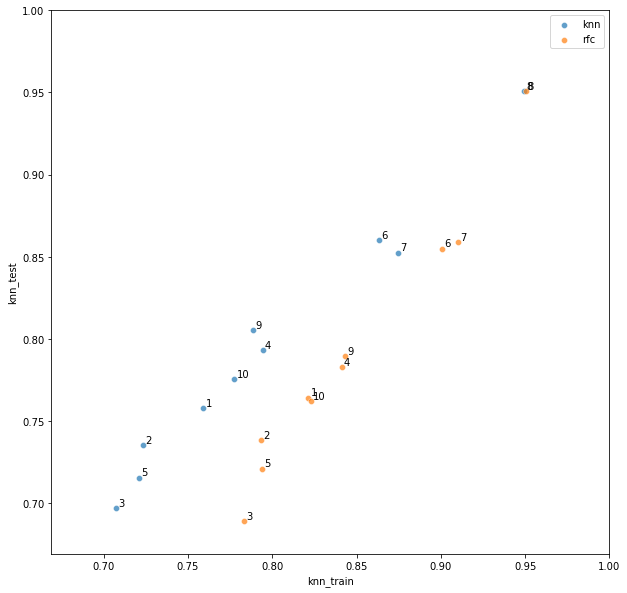

In [162]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(ax=ax, data=scores_df, x='knn_train', y='knn_test', label='knn', alpha=0.7)
sns.scatterplot(ax=ax, data=scores_df, x='rfc_train', y='rfc_test', label='rfc', alpha=0.7)

offset = 0.0013
for x, y, s in zip(scores_df.knn_train, scores_df.knn_test, scores_df.offer_id):
    plt.text(x + offset, y + offset, s)
    
for x, y, s in zip(scores_df.rfc_train, scores_df.rfc_test, scores_df.offer_id):
    plt.text(x + offset, y + offset, s)

# Set axis minimum to be lowest score - offset
lim_min = scores_df.drop(columns='offer_id').min().min() - 0.02
plt.xlim(lim_min, 1)
plt.ylim(lim_min, 1);


In [ ]:
n_neighbors = [e['knn__n_neighbors'] for e in model.cv_results_['params']]

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
param = 'knn__n_neighbors'
sns.lineplot(ax=ax, x=n_neighbors, y=train_score, label='train')
sns.lineplot(ax=ax, x=n_neighbors, y=validation_score, label='validation')
ax.axvline(model.best_params_[param])
ax.set_xlabel(param)
ax.set_ylabel('f1 score')

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
param = 'knn__n_neighbors'
sns.lineplot(ax=ax, x=n_neighbors, y=train_score, label='train')
sns.lineplot(ax=ax, x=n_neighbors, y=validation_score, label='validation')
ax.axvline(model.best_params_[param])
ax.set_xlabel(param)
ax.set_ylabel('f1 score')

## References

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74